<a href="https://colab.research.google.com/github/na-learning/ML-DeepLearning/blob/main/Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
!pip install scikeras

In [71]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from sklearn.pipeline import Pipeline

1. Load the Adult data into a Pandas Dataframe.
2. Ensure the dataset has properly named columns. If the columns are not read in, assign them by referencing the dataset documentation.
3. Display the first five rows of the dataset.

In [72]:
# Download the dataset and load it into a pandas DataFrame
DATA_PATH = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
df = pd.read_csv(DATA_PATH, index_col=False, header=None, names=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship',
                                                'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
                                                ])

# Display the first few rows of the DataFrame
print(df.head())

   age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country  income  
0          2174             0              40   United-States   <=50

1. Do exploratory data analysis to give you some better intuition for the dataset. This is a bit open-ended. How many rows/columns are there? How are NULL values represented? What's the percentage of positive cases in the dataset?

2. Drop all rows with NULL values.

3. Use Scikit-Learn's LabelEncoder to convert the income column with a data type string to a binary variable.

In [73]:
print(df.shape)

df.describe().T

# print(df[df.workclass.str.strip() == '?'])

# null values seem to be represented by '?'



(32561, 15)


,count,mean,std,min,25%,50%,75%,max
age,32561.0,38.581647,13.640433,17.0,28.0,37.0,48.0,90.0
fnlwgt,32561.0,189778.366512,105549.977697,12285.0,117827.0,178356.0,237051.0,1484705.0
education-num,32561.0,10.080679,2.572720,1.0,9.0,10.0,12.0,16.0
capital-gain,32561.0,1077.648844,7385.292085,0.0,0.0,0.0,0.0,99999.0
capital-loss,32561.0,87.303830,402.960219,0.0,0.0,0.0,0.0,4356.0
hours-per-week,32561.0,40.437456,12.347429,1.0,40.0,40.0,45.0,99.0


In [74]:
# Looks like a space char is causing issues when replacing, so will apply strip
cols = df.select_dtypes(object).columns
df[cols] = df[cols].apply(lambda x: x.str.strip())

df[df == '?'] = np.nan
# df.info()

# Columns having null values
null_cols = df.columns[df.isna().any()]
print(null_cols)

# workclass, occupation, native-country are having NULL values

Index(['workclass', 'occupation', 'native-country'], dtype='object')


In [75]:
# Find all NULL values and drop them

df = df.dropna(axis=0)
print(df.shape)

(30162, 15)


In [76]:
# Use Scikit-Learn's LabelEncoder to convert the income column with a data type
# string to a binary variable.

df['income']= LabelEncoder().fit_transform(df['income'])
print(df['income'].unique())

[0 1]


<ipython-input-76-630243aaa992>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['income']= LabelEncoder().fit_transform(df['income'])



Split the data into training and test sets. Remember not to include the label you're trying to predict, income, as a column in your training data.

In [77]:
# Split dataset into training and test sets
X = df.loc[:, df.columns != 'income']
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Use Scikit-Learn's roc_auc_score to calculate the AUC score for a method that always predicts the majority class.

In [78]:
# Use Scikit-Learn's roc_auc_score to calculate the AUC score for a method that
# always predicts the majority class.

# The majority class can be calculated statistically using the mode; that is, the most common observation in a distribution.

from scipy.stats import mode

# predict the majority class
def majority_class(y):
	return mode(y)[0]

# make predictions
y_prob = [majority_class(y_train) for _ in range(len(y_test))]
# calculate accuracy
accuracy = roc_auc_score(y_test, y_prob)
print('ROC AUC Score: %.3f' % accuracy)

ROC AUC Score: 0.500


Use Scikit-Learn's ColumnTransformer to apply One Hot Encoding to the categorical variables in workclass, education, marital-status, occupation, relationship, 'race', sex, and native-country. Also, apply MinMaxScaler to the remaining continuous features. How many columns will the dataframe have after these columns transformations are applied?

In [79]:
numerical_x = X.select_dtypes(include=['int64', 'float64']).columns
categorical_x = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

# print(numerical_x)
# print(categorical_x)
# print(X.columns.size)

t = [('num', MinMaxScaler(), numerical_x), ('cat', OneHotEncoder(sparse_output=False, handle_unknown="ignore"), categorical_x)]

ct = ColumnTransformer(transformers=t, remainder='drop')

In [80]:
# How many columns will the dataframe have after these columns transformations are applied?
# 104 columns
ct.set_output(transform='pandas')
df = ct.fit_transform(df)
df

,num__age,num__fnlwgt,num__education-num,num__capital-gain,num__capital-loss,num__hours-per-week,cat__workclass_Federal-gov,cat__workclass_Local-gov,cat__workclass_Private,cat__workclass_Self-emp-inc,...,cat__native-country_Portugal,cat__native-country_Puerto-Rico,cat__native-country_Scotland,cat__native-country_South,cat__native-country_Taiwan,cat__native-country_Thailand,cat__native-country_Trinadad&Tobago,cat__native-country_United-States,cat__native-country_Vietnam,cat__native-country_Yugoslavia
0,0.301370,0.043338,0.800000,0.021740,0.0,0.397959,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.452055,0.047277,0.800000,0.000000,0.0,0.122449,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.287671,0.137244,0.533333,0.000000,0.0,0.397959,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.493151,0.150212,0.400000,0.000000,0.0,0.397959,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.150685,0.220703,0.800000,0.000000,0.0,0.397959,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0.136986,0.165563,0.733333,0.000000,0.0,0.377551,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
32557,0.315068,0.095589,0.533333,0.000000,0.0,0.397959,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
32558,0.561644,0.093914,0.533333,0.000000,0.0,0.397959,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
32559,0.068493,0.127620,0.533333,0.000000,0.0,0.193878,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


1. Create your own model in Keras to predict income in the Adult training data. Remember, it's always better to start simple and add complexity to the model if necessary. What's a good loss function to use?

2. Keras can be integrated with Scitkit-Learn using a wrapper. Use the KerasClassifier wrapper to integrate your Keras model with the ColumnTransformer from previous steps using a Pipeline object.

3. Fit your model.

4. Calculate the AUC score of your model on the test data. Does the model predict better than random?

5. Generate an ROC curve for your model using RocCurveDisplay. What would the curve look like if all your predictions were randomly generated? What would the curve look like if it you had a perfect model?

In [116]:
# Define the Keras model
model = Sequential()

model.add(Dense(128, input_shape=(104,), activation='relu'))

model.add(Dense(128, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                     │ (None, 128)                 │          13,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,081 (117.50 KB)

 Trainable params: 30,081 (117.50 KB)

 Non-trainable params: 0 (0.00 B)

In [117]:
# Create a Keras classifier
model = KerasClassifier(model=model, epochs=25, batch_size=10, verbose=0)


In [118]:
# Create the scikit-learn pipeline
pipeline = Pipeline(steps=[('trans', ct), ('model', model)])


In [119]:
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('model',
                 KerasClassifier(batch_size=10, epochs=25, model=<Sequential name=sequential_18, built=True>, verbose=0))])

In [127]:
# Calculate the AUC score of your model on the test data.
# Does the model predict better than random?
y_pred_proba = pipeline.predict_proba(X_test)[::,1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print('ROC AUC Score: %.3f' % roc_auc)

# Definitely predicts better than the mode (random) model

ROC AUC Score: 0.894


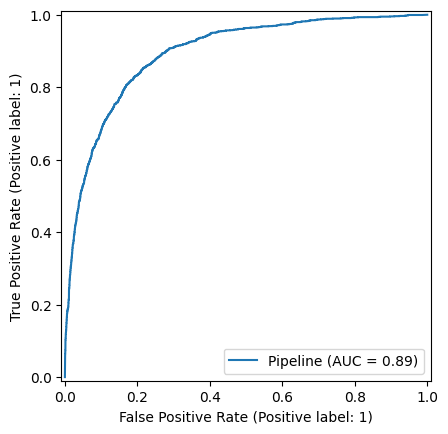

In [128]:
# Generate an ROC curve for your model.
import matplotlib.pyplot as plt
pipeline_disp = RocCurveDisplay.from_estimator(pipeline, X_test, y_test)
plt.show()



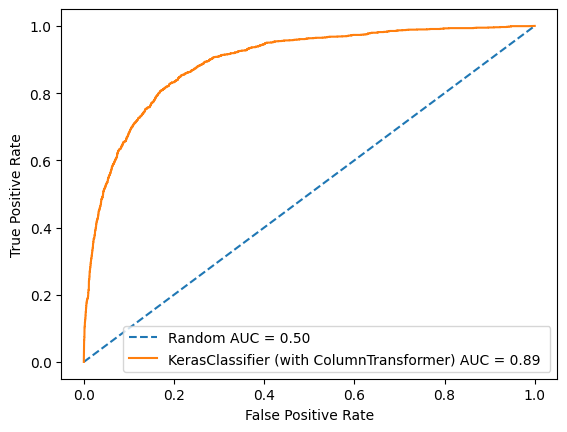

In [129]:
# What would the curve look like if all your predictions were randomly generated? What would the curve look like if it you had a perfect model?
from numpy.random import randint
from sklearn.metrics import roc_curve

random_fpr, random_tpr, _ = roc_curve(y_test, y_prob)
pl_fpr, pl_tpr, thresholds = roc_curve(y_test, y_pred_proba)
# plot the roc curve for the model
plt.plot(random_fpr, random_tpr, linestyle='--', label='Random AUC = %0.2f' % accuracy)
plt.plot(pl_fpr, pl_tpr, label='KerasClassifier (with ColumnTransformer) AUC = %0.2f ' % roc_auc)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

# If we had a perfect model, the curve hugs the top left corner of the plot